<a href="https://colab.research.google.com/github/kregier/AudioLanguageClassifer/blob/main/DataWranglingEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Language Classsifier
Identify the gender and/or native language of speakers reading a fixed passage in English.

The goal is to use the pre-trained VGGish model to extract features from audio files, and train a classifier to identify the gender and/or native language or the speaker.

The data is a subset of the Speech Accent Archive, available from https://www.kaggle.com/rtatman/speech-accent-archive.

This notebook explores the distribution of the speakers in the database, and provides examples of processing steps for the audio files.

Note: Depending on the platform (Google Colab, Paperspace, local machine) used to run this notebook, the filepaths may need to be changed. This notebook will run on the local machine (with the file structure from as in the GitHub repo)

In [1]:
# Install necessary packages, if they are not already installed
# Necessary to run on Colab.
#!pip install pyAudioAnalysis
#!pip install hmmlearn
#!pip install eyed3
#!pip install pydub
#!pip install soundfile

In [2]:
# Install necessary packages for Paperspace
#!apt-get update
#!apt-get install -y ffmpeg
#!apt-get install -y libsndfile-dev

In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import librosa.display

from pyAudioAnalysis import audioSegmentation as aS

import os
import random

print("All set up!")

All set up!


# Data wrangling

## Download the data
These cells need to be run the first time to download the data from Kaggle. Once the data is downloaded and unzipped, they do not need to be run.

In [4]:
# Copy Kaggle API command - only needs to be done the first time
#!kaggle datasets download -d rtatman/speech-accent-archive

In [5]:
# unzip the zip files and remove the zip files - only needs to be done the first time
#!unzip \*.zip && rm *.zip

##  Set up variables to access the downloaded data (on the appropriate platform)

In [6]:
!pwd

/Users/ktregier/Documents/Repositories/AudioLanguageClassifer/notebooks


In [7]:
!ls

1_ktr_EDA.ipynb                       Local -Figures.ipynb
6_Figures_Local.ipynb                 PS-Augmentation.ipynb
CodeInterviewProblem.ipynb            PS-EDA.ipynb
CodeInterviewSolution.ipynb           PS-GenderClassifier.ipynb
DataAugmentationExperimentation.ipynb PS-GenderEval.ipynb
DataWranglingEDA-Collab.ipynb         PS-LangClassifier.ipynb
GenderClassifier.ipynb                PS-LangEval.ipynb
InputFeatureExtraction.ipynb          PreprocessAudio.ipynb
LanguageClassifier.ipynb              SampleModel.ipynb
LanguageClassifier2.ipynb


In [2]:
DATA_PATH = '../data/'
DATA_ORIG_PATH = DATA_PATH + 'original/'
DATA_PROCESS_PATH = DATA_PATH + 'processed/'
FIG_PATH = '../reports/figures/'

## Load the data and metadata

In [3]:
textpath = DATA_ORIG_PATH + 'reading-passage.txt'
text = pd.read_csv(textpath, header=None, delimiter='.')
text.head().T

,0
0,Please call Stella
1,Ask her to bring these things with her from ...
2,We also need a small plastic snake and a big...
3,She can scoop these things into three red ba...
4,NaN


In [4]:
metapath = DATA_ORIG_PATH + 'speakers_all.csv'
meta = pd.read_csv(metapath)
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [5]:
# Drop 3 end columns with NaN values
meta.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1, inplace=True)

# Set speakerid as index
meta.set_index('speakerid', inplace=True)
meta.sort_index(inplace=True)
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


In [6]:
meta.shape

(2172, 8)

# EDA
- How many unique values and missing values per column?
- How many speakers per native language?
- What are the top languages present in the database?
- What is the distribution of speakers by gender and language?
- How many dialects of English are represented? (native_language == English, by birthplace and country values)


### Unique and missing value

In [12]:
# How many unique values are there per column?
meta.nunique()

age                  80
age_onset            59
birthplace         1290
filename           2156
native_language     214
sex                   3
country             176
file_missing?         2
dtype: int64

In [13]:
# How many columns have null values?
meta.isnull().sum()

age                0
age_onset          0
birthplace         4
filename           0
native_language    0
sex                0
country            5
file_missing?      0
dtype: int64

In [14]:
meta[meta.birthplace.isnull()]

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
355,0.0,0.0,NaN,synthesized1,synthesized,male,NaN,False
356,0.0,0.0,NaN,synthesized2,synthesized,female,NaN,False
357,0.0,0.0,NaN,synthesized3,synthesized,female,NaN,False
358,0.0,0.0,NaN,synthesized4,synthesized,male,NaN,False


In [15]:
meta[meta.country.isnull()]

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
249,25.0,21.0,"vientiane, laos,",lao2,lao,female,NaN,False
355,0.0,0.0,NaN,synthesized1,synthesized,male,NaN,False
356,0.0,0.0,NaN,synthesized2,synthesized,female,NaN,False
357,0.0,0.0,NaN,synthesized3,synthesized,female,NaN,False
358,0.0,0.0,NaN,synthesized4,synthesized,male,NaN,False


It makes sense that the synthesized audio files would not have birthplace or country information.
Since I want to train the model on real voices, I will delete the synthesized voices from the data.

In [16]:
meta.dropna(subset=['birthplace'], inplace=True)

# Look at the  missing value in the country column
meta[meta.native_language=='lao']

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
248,19.0,12.0,"savannakhet, laos",lao1,lao,female,laos,False
249,25.0,21.0,"vientiane, laos,",lao2,lao,female,NaN,False
2007,52.0,20.0,"pakxe, laos",lao3,lao,male,laos,False


The remaining missing value is in the country column from one Lao speaker. Since the other two Lao speakers have Laos as their country, I will impute Laos as the country value for the remaining speaker as well.

In [17]:
meta.loc[meta.country.isnull(), 'country'] = 'laos'
meta.isnull().sum()

age                0
age_onset          0
birthplace         0
filename           0
native_language    0
sex                0
country            0
file_missing?      0
dtype: int64

In [18]:
meta.shape

(2168, 8)

### Missing files column
What are the missing files? If there are missing audio files, they will not be available for feature extraction, so they should be removed from the dataframe before the audio files are processed.

In [19]:
meta['file_missing?'].value_counts()

False    2136
True       32
Name: file_missing?, dtype: int64

In [20]:
missingIdx = meta[meta['file_missing?']==True].index
meta.loc[missingIdx].head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
318,28.0,11.0,"colombo, sri lanka",sinhalese2,sinhalese,female,sri lanka,True
380,38.0,4.0,"madang, madang province, papua new guinea",tok,tok,male,papua new guinea,True
425,25.0,5.0,"jammu, kashmir, india",poonchi1,poonchi,male,india,True
461,25.0,8.0,"colombo, sri lanka",sinhalese3,sinhalese,female,sri lanka,True
493,21.0,10.0,"eischoll, switzerland",swiss,swiss,male,switzerland,True


In [21]:
meta.loc[missingIdx, 'filename'].value_counts()

haitian        6
swiss          5
nicaragua      3
jamaican       3
liberian       2
hawai'i        2
tetun-dili1    1
balanta        1
sinhalese4     1
sinhalese2     1
poonchi1       1
cameroon       1
sinhalese3     1
tok            1
fulfulde       1
sinhalese5     1
northern       1
Name: filename, dtype: int64

The speakers with missing audio files don't necessarily have unique filenames, which means the files won't be able to be loaded - which is a moot point since the files don't exist. I'm going to remove these records from the data, since they don't have associated sound files.

Based on previous attempts to load the audio files, several other files are missing, so they will be removed too.

In [22]:
# Remove records with missing files - The files don't have unique names, and are not available in the recordings folder.
meta.drop(missingIdx, inplace=True )
meta.shape

(2136, 8)

In [23]:
# Based on trying to load the files in previous runs, these audio files are missing, so the records should be removed.
nica_index = meta[meta.filename == 'nicaragua'].index
sinhalese_index = meta[meta.filename=='sinhalese1'].index
meta.drop(nica_index, inplace=True, axis=0)
meta.drop(sinhalese_index, inplace=True, axis=0)
meta.shape

(2134, 8)

### How many speakers per native language?

In [24]:
# How many native languages, total?
meta.native_language.nunique()

199

In [25]:
# Hard to see the scope because there are so many with only one speaker
meta.native_language.value_counts()

english     579
spanish     162
arabic      102
mandarin     65
french       63
           ... 
lingala       1
taishan       1
sicilian      1
agni          1
hindko        1
Name: native_language, Length: 199, dtype: int64

In [26]:
# How many native languages with only one speaker in the database?
meta.native_language.value_counts().loc[meta.native_language.value_counts() == 1]

rundi        1
konkani      1
edo          1
yakut        1
sardinian    1
            ..
lingala      1
taishan      1
sicilian     1
agni         1
hindko       1
Name: native_language, Length: 78, dtype: int64

There are 78 native languages represented by only one speaker in the database. This means there are 121 languages represented by 2 or more speakers.

### What are the top 10 languages in the data, in addition to English?

In [27]:
lang_counts = meta.native_language.value_counts().head(11)
lang_counts

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
russian        48
portuguese     48
dutch          47
turkish        37
german         36
Name: native_language, dtype: int64

In [28]:
lang_list = ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'russian', 
             'portuguese', 'dutch', 'turkish', 'german']
top_lang = meta.loc[meta.native_language.isin(lang_list)]
top_lang['Native Language'] = top_lang['native_language'].str.capitalize()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

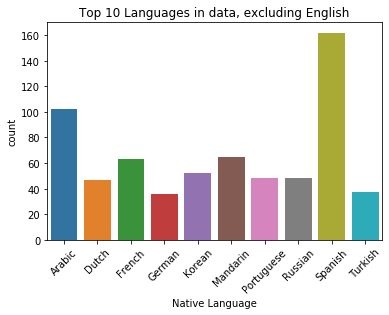

In [29]:
sns.countplot(x='Native Language', data=top_lang)
plt.title('Top 10 Languages in data, excluding English')
plt.xticks(rotation=45)

### What is the distribution of speakers by gender?

In [30]:
# There is one record with 'famale', which is assumed to be a typo.
type_idx = meta[meta.sex =='famale'].index
meta.loc[type_idx, 'sex'] = 'female'
meta.sex.value_counts()

male      1100
female    1034
Name: sex, dtype: int64

Text(0.5, 1.0, 'Distibution of speakers by gender - All')

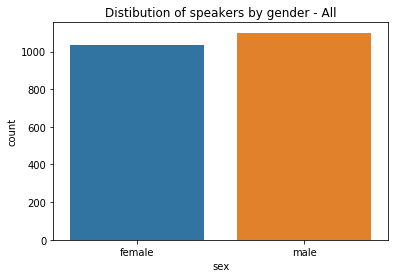

In [31]:
sns.countplot(x='sex', data=meta)
plt.title('Distibution of All Speakers by Gender')

Text(0.5, 1.0, 'Distribution of speakers by gender - Top 10')

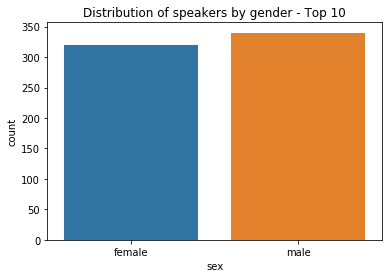

In [32]:
sns.countplot(x='sex', data=top_lang)
plt.title('Distribution of Speakers by Gender - Top 10')

### How are the native Engish speakers distributed by country?
There are many different varieties of English spoken in the world. While we can't find out exactly which variety each speaker uses, we can infer the variety by looking at their birthplace and country.

In [33]:
# How many varieties of English are represented in the database?
english = meta.loc[meta.native_language == 'english']
english.country.value_counts()

usa                     373
uk                       65
canada                   44
australia                32
ireland                  11
new zealand               8
jamaica                   5
singapore                 4
south africa              4
panama                    3
india                     3
malaysia                  2
guyana                    2
philippines               2
the bahamas               1
us virgin islands         1
germany                   1
united arab emirates      1
antigua and barbuda       1
liberia                   1
belize                    1
nigeria                   1
isle of man               1
italy                     1
spain                     1
pakistan                  1
bolivia                   1
papua new guinea          1
virginia                  1
fiji                      1
ghana                     1
trinidad                  1
switzerland               1
lebanon                   1
barbados                  1
Name: country, dtype

In [34]:
english.country.nunique()

35

Text(0.5, 1.0, 'Native English Speakers by Country')

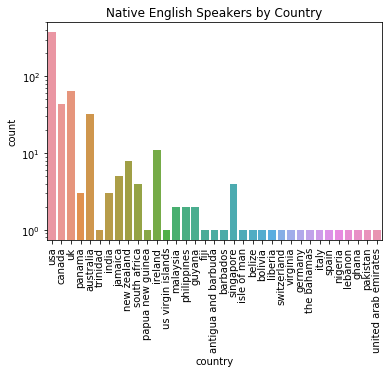

In [35]:
sns.countplot(x='country', data=english)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Native English Speakers by Country')

In [36]:
english.birthplace.value_counts()

sydney, australia                        8
toronto, ontario, canada                 7
washington, district of columbia, usa    7
chicago, illinois, usa                   6
dublin, ireland                          6
                                        ..
dickenson county, virginia, usa          1
birmingham 1, uk                         1
darwin, australia                        1
port elizabeth, south africa             1
hazlehurst, georgia, usa                 1
Name: birthplace, Length: 421, dtype: int64

In [37]:
english.birthplace.str.contains('usa').sum()

373

In [38]:
english.birthplace.str.contains('uk').sum()

67

In [39]:
english.birthplace.str.contains('canada').sum()

44

In [40]:
english.birthplace.str.contains('australia').sum()

32

The birthplace column is a bit hard to parse for country, since the column entries include cities, optional provinces/states, and country. However, the number of speakers from each country by birthplace seem to correspond to a high degree, when the birthplace column is filtered for the top 4 "countries".

### Save modified dataframe for later reference

In [41]:
meta.shape

(2134, 8)

In [42]:
meta.isnull().sum()

age                0
age_onset          0
birthplace         0
filename           0
native_language    0
sex                0
country            0
file_missing?      0
dtype: int64

In [43]:
processpath = '{}processed.csv'.format(DATA_PROCESS_PATH)
#meta.to_csv('processed.csv')

# Explore the audio files
## Segmentation
Since the speakers read a fixed English passage with 4 sentences, I expect that the resulting audio files are going to be fairly long.

First, we will load a random file to see how long it is, and to examine how it can be segmented into smaller segments at pauses.

In [44]:
# Choose a random sound file to examine
filename = random.choice(meta.filename)
filepath = '{}recordings/recordings/{}.mp3'.format(DATA_ORIG_PATH, filename)
print(filepath)

../data/original/recordings/recordings/french10.mp3


In [45]:
ipd.Audio(filepath)

In [46]:
# Set sample rate to 16k, to fit with Vggish model
SAMP_RATE = 16000
y, sr = librosa.load(filepath, sr=SAMP_RATE)

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning:

PySoundFile failed. Trying audioread instead.



../reports/figures/Waveform_french10.png


<Figure size 1080x216 with 0 Axes>

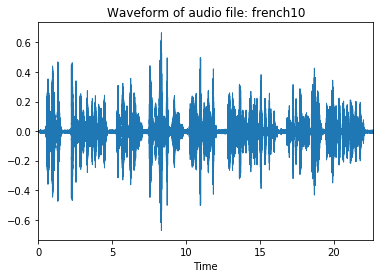

In [47]:
plt.figure(figsize=(15, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Waveform of audio file: {}'.format(filename))
print('{}Waveform_{}.png'.format(FIG_PATH, filename))
#plt.savefig('{}Waveform{}.png'.format(FIG_PATH, filename))

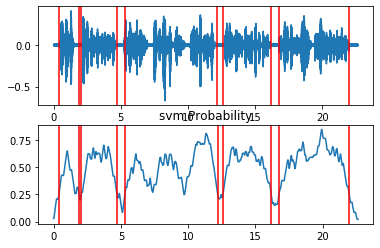

In [48]:
# https://github.com/tyiannak/pyAudioAnalysis/wiki/5.-Segmentation

# segments is a list of endpoints
segments = aS.silence_removal(y, SAMP_RATE, 0.020, 0.020, smooth_window = 1.0, weight = 0.15, plot = True)

In [49]:
print(segments)

[[0.4, 1.9000000000000001], [2.06, 4.7], [5.3, 12.200000000000001], [12.6, 16.18], [16.76, 21.98]]


### Comments on segmentation
Running the segmentation algorithm on a variety of different files elsewhere gives different results for different audio files. Some segments are really short, while others are longer. Most files are segmented into at least 4 segments, with some having 8-10 segments, many of which are very short.

While the original idea was to try to segment the files into approximately 4 segments, which correspond roughly to the 4 phrases in the text passage, these segments end up being (much) shorter than the files on which the VGGish model was trained.

At this point, my plan is to segment the files into 10s segments, which correspond to the length of the training files for VGGish. For most of the files in this data set, this will result in at least 2 segments, with up to 5 segments. Segmenting the files into fixed length segments can be done by index slicing on the original file, and don't involve outside functions.

In [50]:
def segment_10s(audio, sr):
    """Load an audio file and divide into 10 second segments.
    Arguments: audio - the audio file; 
    sr = sampling rate of the file
    Returns: a dictionary of the audio segments. Key is the index of segment, value is the segment."""

    seg_files ={}
    n_seg = int((len(audio)/sr)/10)
    for i in range(n_seg):
        segment = audio[10*i*sr:(i+1)*10*sr]
        seg_files[i] = segment
    return seg_files

In [51]:
# Test segment_10s fuction on the sample audio file
y_seg = segment_10s(y, SAMP_RATE)
print(y_seg.keys())

dict_keys([0, 1])


In [52]:
ipd.Audio(y_seg[0], rate=SAMP_RATE)

In [53]:
ipd.Audio(y_seg[1], rate=SAMP_RATE)

## Augment with noise
One way to make the model more robust is to add random noise to the audio files, which double the number of training files, and forces the model to focus on the relevant features while ignoring the noise.

In [54]:
def add_noise(audio):
    '''
    Add random noise to an audio file.
    Arguments: audio - the audio file
    Returns: the noisy audio file
    ''' 
    # Load random number generator
    rng = np.random.default_rng()
    # Generate random noise
    noise = rng.standard_normal(len(audio))
    # Add noise to file
    noisy_seg = audio + 0.005*noise

    return noisy_seg

In [55]:
# Test the add_noise function on the sample soundfile
y_noise = add_noise(y_seg[0])
ipd.Audio(y_noise, rate=SAMP_RATE)

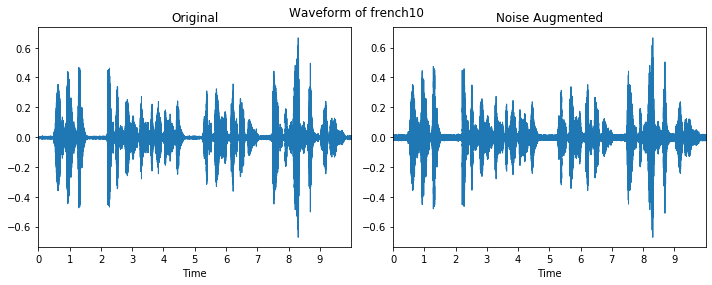

In [56]:
fig, axn = plt.subplots(1, 2, figsize=(10,4))

librosa.display.waveplot(y_seg[0], sr=SAMP_RATE, ax=axn[0])
axn[0].set_title('Original')


librosa.display.waveplot(y_noise, sr=SAMP_RATE, ax=axn[1])
axn[1].set_title('Noise Augmented')

plt.suptitle('Waveform of {}'.format(filename))
plt.tight_layout()
#plt.savefig('../OrigNoise.png')

## Extract mel spectrogram
Internally, the VGGish algorith converts the audiofile into a melspectrogram, which is the input to the first convolutional layer of the VGGish model.

This section of code generates mel spectrograms similar to those that will be generated by the VGGish model, for inspection.

In [57]:
# Mel spectrogram parameters
N_MEL_BANDS = 64
FREQ_MIN = 125
FREQ_MAX = 7500
HOP = 1667
WIN = 400
FFT = 512

In [58]:
mel_spec = librosa.feature.melspectrogram(y_seg[0], SAMP_RATE, n_mels=N_MEL_BANDS, 
                                     fmin=FREQ_MIN, fmax=FREQ_MAX,
                                     hop_length=HOP, n_fft=FFT)

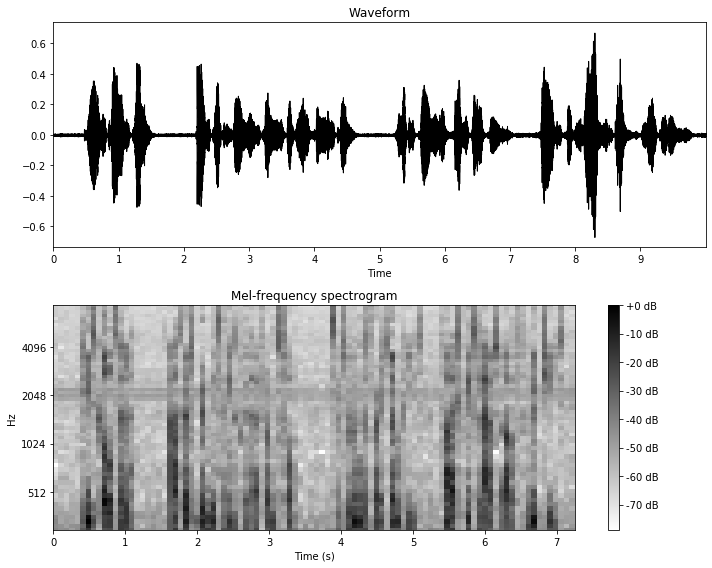

In [60]:
fig, axn = plt.subplots(2, 1, figsize=(10, 8))
librosa.display.waveplot(y_seg[0], sr=SAMP_RATE, ax=axn[0], color='k')
axn[0].set(title='Waveform of {}'.format(filename))
 
mel_db = librosa.power_to_db(mel_spec, ref=np.max)
img = librosa.display.specshow(mel_db, x_axis='s', y_axis='mel', 
                               ax=axn[1], fmin=FREQ_MIN, fmax=FREQ_MAX,
                               cmap='gray_r', hop_length=HOP)#,
                               # n_fft=512) #win_length=win_size,
fig.colorbar(img, ax=axn[1], format='%+2.0f dB')
axn[1].set(title="Mel-frequency spectrogram")
plt.tight_layout()

The next notebook is 2_ktr_Augmentation, which will split the speakers into training, validation and testing sets, then process the audio files by dividing them into 10s segments and addding random noise.

# Selected references
Data from: https://www.kaggle.com/rtatman/speech-accent-archive/notebooks

Inspiration and examples from: https://www.kaggle.com/ejlok1/part-2-extracting-audio-features